# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [9]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

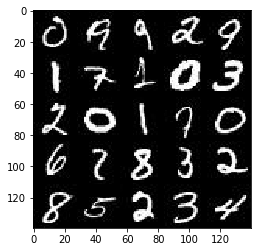

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

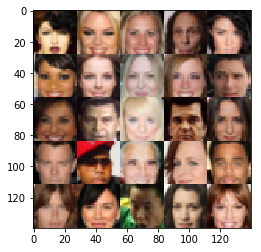

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [13]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, (None), name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [94]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("discriminator", reuse=reuse):
        
        x = tf.layers.conv2d(images, 128, 5, strides=2, padding="same")
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d(x, 512, 5, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha*x, x)
        
        flatten = tf.reshape(x, (-1, 4*4*512)) 
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [93]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    k_init = tf.random_normal_initializer(stddev=0.02)
    # Idea to add kernel_initializer from @theiagoqd
    # https://github.com/thiagoqd/queirozdias-deep-learning/blob/master/face_generation/dlnd_face_generation.ipynb
    with tf.variable_scope("generator", reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*512)
        
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, kernel_initializer=k_init, padding="same")
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=k_init, padding="same")
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=k_init, padding="same")
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    _, d_logits_real = discriminator(input_real, reuse=False)
    gen = generator(input_z, out_channel_dim, is_train=True)
    d_out_fake, d_logits_fake = discriminator(gen, reuse=True)
    
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_logits_real)*(1-smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real+d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [97]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    # Update Opts idea from Zhenyu Wang on Slack
    # https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [84]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, l, w, c = data_shape
    input_real, input_z, _ = model_inputs(l, w, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_train_opt , g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    idx = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                idx += 1 

                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if idx % 10 == 0 : 
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                if idx % 100 == 0 : 
                    show_generator_output(sess, 25, input_z, c, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6478... Generator Loss: 4.5672
Epoch 1/2... Discriminator Loss: 0.3758... Generator Loss: 3.4954
Epoch 1/2... Discriminator Loss: 1.1364... Generator Loss: 15.3463
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 0.9937
Epoch 1/2... Discriminator Loss: 0.8439... Generator Loss: 1.7090
Epoch 1/2... Discriminator Loss: 0.6818... Generator Loss: 6.3860
Epoch 1/2... Discriminator Loss: 0.7666... Generator Loss: 2.8794
Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 1.4566
Epoch 1/2... Discriminator Loss: 0.7485... Generator Loss: 2.1636
Epoch 1/2... Discriminator Loss: 1.5685... Generator Loss: 3.6834


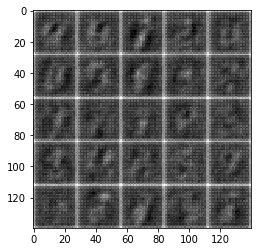

Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 0.8319
Epoch 1/2... Discriminator Loss: 1.3022... Generator Loss: 2.9075
Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 0.9070
Epoch 1/2... Discriminator Loss: 0.8788... Generator Loss: 2.3759
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.7490
Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 0.9355
Epoch 1/2... Discriminator Loss: 0.8772... Generator Loss: 1.0492
Epoch 1/2... Discriminator Loss: 1.6379... Generator Loss: 0.4524
Epoch 1/2... Discriminator Loss: 0.8797... Generator Loss: 2.1138
Epoch 1/2... Discriminator Loss: 0.7355... Generator Loss: 2.0481


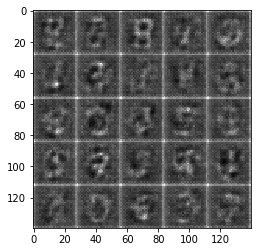

Epoch 1/2... Discriminator Loss: 0.7819... Generator Loss: 1.2866
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 0.9029
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 1.0552
Epoch 1/2... Discriminator Loss: 0.6547... Generator Loss: 1.7953
Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 4.0794
Epoch 1/2... Discriminator Loss: 0.7936... Generator Loss: 1.5124
Epoch 1/2... Discriminator Loss: 0.7499... Generator Loss: 1.4153
Epoch 1/2... Discriminator Loss: 0.7125... Generator Loss: 2.1797
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 1.2737
Epoch 1/2... Discriminator Loss: 0.6716... Generator Loss: 1.4785


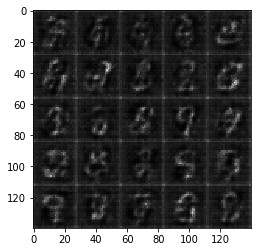

Epoch 1/2... Discriminator Loss: 0.6258... Generator Loss: 2.1203
Epoch 1/2... Discriminator Loss: 0.7119... Generator Loss: 1.4692
Epoch 1/2... Discriminator Loss: 0.7738... Generator Loss: 1.6935
Epoch 1/2... Discriminator Loss: 1.9431... Generator Loss: 0.3360
Epoch 1/2... Discriminator Loss: 0.6055... Generator Loss: 1.9028
Epoch 1/2... Discriminator Loss: 0.6148... Generator Loss: 1.9240
Epoch 1/2... Discriminator Loss: 0.6406... Generator Loss: 1.6469
Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 0.9478... Generator Loss: 3.0638
Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 1.3282


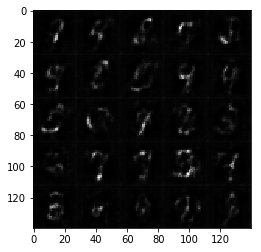

Epoch 1/2... Discriminator Loss: 0.5820... Generator Loss: 2.0154
Epoch 1/2... Discriminator Loss: 0.7012... Generator Loss: 1.4576
Epoch 1/2... Discriminator Loss: 0.6031... Generator Loss: 1.8527
Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 1.3910
Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 1.7862
Epoch 1/2... Discriminator Loss: 0.6815... Generator Loss: 1.5030
Epoch 1/2... Discriminator Loss: 0.5089... Generator Loss: 2.2966
Epoch 1/2... Discriminator Loss: 1.3781... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 0.5802... Generator Loss: 2.5384
Epoch 1/2... Discriminator Loss: 0.6015... Generator Loss: 2.1756


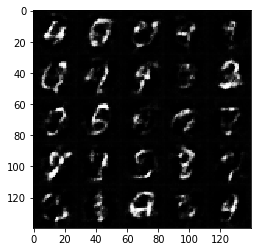

Epoch 1/2... Discriminator Loss: 0.5794... Generator Loss: 2.7081
Epoch 1/2... Discriminator Loss: 0.5870... Generator Loss: 2.2375
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 1.8332
Epoch 1/2... Discriminator Loss: 0.5828... Generator Loss: 2.4093
Epoch 1/2... Discriminator Loss: 0.5730... Generator Loss: 1.9304
Epoch 1/2... Discriminator Loss: 0.6001... Generator Loss: 2.1095
Epoch 1/2... Discriminator Loss: 0.5953... Generator Loss: 1.7309
Epoch 1/2... Discriminator Loss: 0.8662... Generator Loss: 1.0971
Epoch 1/2... Discriminator Loss: 0.5487... Generator Loss: 2.0787
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 1.7685


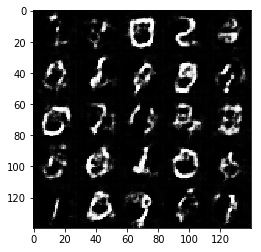

Epoch 1/2... Discriminator Loss: 0.6108... Generator Loss: 2.0703
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 0.7527
Epoch 1/2... Discriminator Loss: 0.8273... Generator Loss: 1.1736
Epoch 1/2... Discriminator Loss: 0.5958... Generator Loss: 1.9454
Epoch 1/2... Discriminator Loss: 0.7515... Generator Loss: 2.1700
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 2.5668
Epoch 1/2... Discriminator Loss: 1.1003... Generator Loss: 3.5815
Epoch 1/2... Discriminator Loss: 0.7666... Generator Loss: 1.8133
Epoch 1/2... Discriminator Loss: 0.9533... Generator Loss: 0.9900
Epoch 1/2... Discriminator Loss: 0.7991... Generator Loss: 1.3701


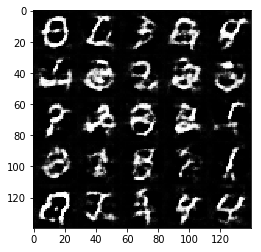

Epoch 1/2... Discriminator Loss: 0.7794... Generator Loss: 1.3752
Epoch 1/2... Discriminator Loss: 0.7239... Generator Loss: 1.8140
Epoch 1/2... Discriminator Loss: 0.6750... Generator Loss: 1.4783
Epoch 1/2... Discriminator Loss: 0.7391... Generator Loss: 1.6004
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 2.4797
Epoch 1/2... Discriminator Loss: 0.6687... Generator Loss: 1.5595
Epoch 1/2... Discriminator Loss: 0.7069... Generator Loss: 1.6104
Epoch 1/2... Discriminator Loss: 0.7857... Generator Loss: 1.2677
Epoch 1/2... Discriminator Loss: 0.6557... Generator Loss: 2.0561
Epoch 1/2... Discriminator Loss: 0.7127... Generator Loss: 1.5588


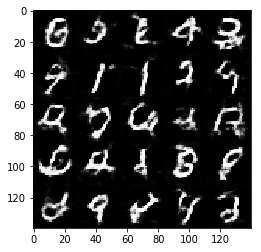

Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 0.9817
Epoch 1/2... Discriminator Loss: 0.6549... Generator Loss: 1.7770
Epoch 1/2... Discriminator Loss: 0.7195... Generator Loss: 1.4856
Epoch 1/2... Discriminator Loss: 0.6990... Generator Loss: 2.4758
Epoch 1/2... Discriminator Loss: 0.6624... Generator Loss: 1.7806
Epoch 1/2... Discriminator Loss: 0.7538... Generator Loss: 2.2235
Epoch 1/2... Discriminator Loss: 0.7210... Generator Loss: 1.3873
Epoch 1/2... Discriminator Loss: 0.9804... Generator Loss: 1.0119
Epoch 1/2... Discriminator Loss: 0.7436... Generator Loss: 1.3552
Epoch 1/2... Discriminator Loss: 0.7269... Generator Loss: 1.6278


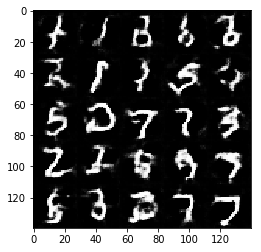

Epoch 1/2... Discriminator Loss: 0.7991... Generator Loss: 1.2779
Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 1.5350
Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 1.1794
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 0.6702
Epoch 1/2... Discriminator Loss: 0.8180... Generator Loss: 2.2951
Epoch 1/2... Discriminator Loss: 0.7922... Generator Loss: 1.4162
Epoch 1/2... Discriminator Loss: 0.6990... Generator Loss: 1.9071
Epoch 1/2... Discriminator Loss: 1.1121... Generator Loss: 3.0472
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 0.9966
Epoch 1/2... Discriminator Loss: 0.7593... Generator Loss: 1.4272


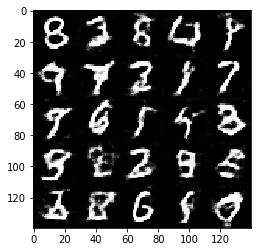

Epoch 1/2... Discriminator Loss: 0.8151... Generator Loss: 1.2997
Epoch 1/2... Discriminator Loss: 0.6795... Generator Loss: 1.6245
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 0.9854
Epoch 1/2... Discriminator Loss: 0.8010... Generator Loss: 1.2256
Epoch 1/2... Discriminator Loss: 0.8319... Generator Loss: 1.1568
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 0.9256
Epoch 1/2... Discriminator Loss: 0.8036... Generator Loss: 1.6755
Epoch 1/2... Discriminator Loss: 0.9236... Generator Loss: 1.0136
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 2.4276
Epoch 1/2... Discriminator Loss: 0.6378... Generator Loss: 1.6346


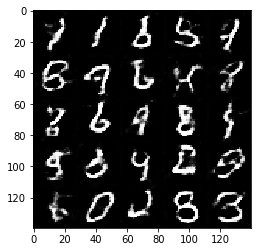

Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 0.9843
Epoch 1/2... Discriminator Loss: 0.6452... Generator Loss: 2.2897
Epoch 1/2... Discriminator Loss: 0.6670... Generator Loss: 1.6683
Epoch 1/2... Discriminator Loss: 0.6730... Generator Loss: 1.6589
Epoch 1/2... Discriminator Loss: 0.7270... Generator Loss: 1.9025
Epoch 1/2... Discriminator Loss: 0.8092... Generator Loss: 1.2494
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.1423
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 0.7240
Epoch 1/2... Discriminator Loss: 0.6585... Generator Loss: 1.7959
Epoch 1/2... Discriminator Loss: 0.6705... Generator Loss: 2.1965


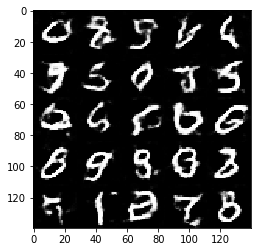

Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 1.1624
Epoch 1/2... Discriminator Loss: 0.5859... Generator Loss: 2.1437
Epoch 1/2... Discriminator Loss: 0.6760... Generator Loss: 1.4755
Epoch 1/2... Discriminator Loss: 0.6754... Generator Loss: 1.5613
Epoch 1/2... Discriminator Loss: 1.1657... Generator Loss: 0.7333
Epoch 1/2... Discriminator Loss: 0.8241... Generator Loss: 1.1405
Epoch 1/2... Discriminator Loss: 0.7209... Generator Loss: 1.3591
Epoch 1/2... Discriminator Loss: 0.6070... Generator Loss: 1.7473
Epoch 1/2... Discriminator Loss: 0.8718... Generator Loss: 1.1353
Epoch 1/2... Discriminator Loss: 0.6743... Generator Loss: 2.0366


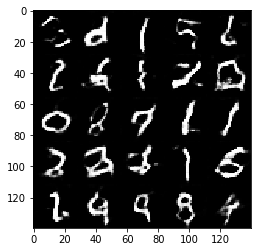

Epoch 1/2... Discriminator Loss: 0.6204... Generator Loss: 2.2586
Epoch 1/2... Discriminator Loss: 0.7106... Generator Loss: 1.2908
Epoch 1/2... Discriminator Loss: 0.7009... Generator Loss: 1.3359
Epoch 1/2... Discriminator Loss: 0.6535... Generator Loss: 1.5228
Epoch 1/2... Discriminator Loss: 0.6995... Generator Loss: 1.4204
Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 1.9647
Epoch 1/2... Discriminator Loss: 0.6830... Generator Loss: 1.5964
Epoch 1/2... Discriminator Loss: 0.8004... Generator Loss: 1.2973
Epoch 1/2... Discriminator Loss: 0.5988... Generator Loss: 1.7416
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 1.4170


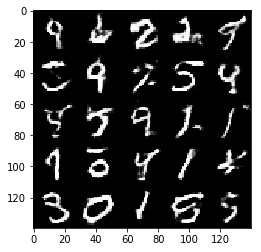

Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.5891
Epoch 1/2... Discriminator Loss: 0.6912... Generator Loss: 1.4225
Epoch 1/2... Discriminator Loss: 1.0521... Generator Loss: 3.2296
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 0.9616
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.1218
Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 1.3075
Epoch 1/2... Discriminator Loss: 0.6625... Generator Loss: 1.7244
Epoch 1/2... Discriminator Loss: 0.7547... Generator Loss: 1.2585
Epoch 1/2... Discriminator Loss: 0.7666... Generator Loss: 1.1793
Epoch 1/2... Discriminator Loss: 0.8145... Generator Loss: 1.0733


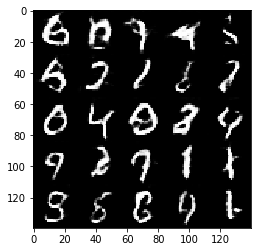

Epoch 1/2... Discriminator Loss: 0.7896... Generator Loss: 1.2007
Epoch 1/2... Discriminator Loss: 0.7010... Generator Loss: 1.4175
Epoch 1/2... Discriminator Loss: 0.8400... Generator Loss: 1.1484
Epoch 1/2... Discriminator Loss: 2.0987... Generator Loss: 0.3277
Epoch 1/2... Discriminator Loss: 0.9929... Generator Loss: 0.9108
Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 1.6218
Epoch 1/2... Discriminator Loss: 0.6898... Generator Loss: 1.4397
Epoch 1/2... Discriminator Loss: 0.6396... Generator Loss: 1.5278
Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 0.8109
Epoch 1/2... Discriminator Loss: 0.7443... Generator Loss: 1.3795


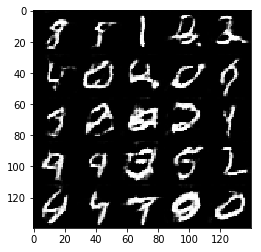

Epoch 1/2... Discriminator Loss: 0.9060... Generator Loss: 2.6300
Epoch 1/2... Discriminator Loss: 0.8496... Generator Loss: 1.1946
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 1.1091
Epoch 1/2... Discriminator Loss: 0.7303... Generator Loss: 1.5273
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.9170
Epoch 1/2... Discriminator Loss: 0.8721... Generator Loss: 1.1007
Epoch 1/2... Discriminator Loss: 0.5979... Generator Loss: 1.8193
Epoch 1/2... Discriminator Loss: 0.9385... Generator Loss: 1.0004
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.6601
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.9563


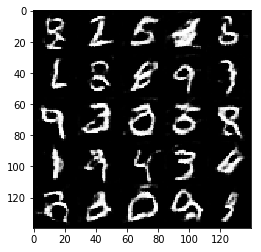

Epoch 1/2... Discriminator Loss: 0.6131... Generator Loss: 1.8834
Epoch 1/2... Discriminator Loss: 0.6443... Generator Loss: 1.9884
Epoch 1/2... Discriminator Loss: 0.7564... Generator Loss: 1.2488
Epoch 1/2... Discriminator Loss: 0.8590... Generator Loss: 1.1452
Epoch 1/2... Discriminator Loss: 0.7086... Generator Loss: 1.4495
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.5390
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 1.8496
Epoch 1/2... Discriminator Loss: 0.6753... Generator Loss: 1.5905
Epoch 1/2... Discriminator Loss: 0.7830... Generator Loss: 1.2785
Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 0.8767


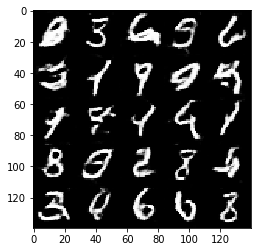

Epoch 1/2... Discriminator Loss: 0.6703... Generator Loss: 1.8741
Epoch 1/2... Discriminator Loss: 1.1386... Generator Loss: 2.4895
Epoch 1/2... Discriminator Loss: 0.8407... Generator Loss: 1.0798
Epoch 1/2... Discriminator Loss: 0.5678... Generator Loss: 1.9367
Epoch 1/2... Discriminator Loss: 0.6354... Generator Loss: 1.7828
Epoch 1/2... Discriminator Loss: 0.6830... Generator Loss: 1.4422
Epoch 1/2... Discriminator Loss: 0.6820... Generator Loss: 1.5304
Epoch 2/2... Discriminator Loss: 0.6239... Generator Loss: 1.8176
Epoch 2/2... Discriminator Loss: 1.4324... Generator Loss: 0.5084
Epoch 2/2... Discriminator Loss: 0.8675... Generator Loss: 1.0631


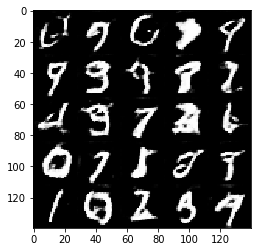

Epoch 2/2... Discriminator Loss: 0.6051... Generator Loss: 2.0072
Epoch 2/2... Discriminator Loss: 0.8061... Generator Loss: 1.3945
Epoch 2/2... Discriminator Loss: 0.8637... Generator Loss: 1.3671
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 1.2890
Epoch 2/2... Discriminator Loss: 0.5889... Generator Loss: 1.8157
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 1.4125
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 1.1422
Epoch 2/2... Discriminator Loss: 0.6909... Generator Loss: 2.0092
Epoch 2/2... Discriminator Loss: 0.7826... Generator Loss: 1.1833


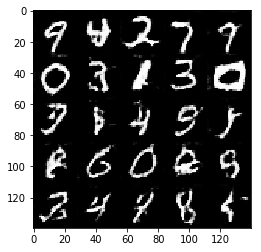

Epoch 2/2... Discriminator Loss: 0.7922... Generator Loss: 1.1890
Epoch 2/2... Discriminator Loss: 0.6535... Generator Loss: 1.5721
Epoch 2/2... Discriminator Loss: 0.8059... Generator Loss: 1.8523
Epoch 2/2... Discriminator Loss: 0.6440... Generator Loss: 2.2606
Epoch 2/2... Discriminator Loss: 0.7213... Generator Loss: 1.4706
Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 0.9981
Epoch 2/2... Discriminator Loss: 0.8016... Generator Loss: 1.4031
Epoch 2/2... Discriminator Loss: 1.1518... Generator Loss: 0.8268
Epoch 2/2... Discriminator Loss: 0.6377... Generator Loss: 1.6359
Epoch 2/2... Discriminator Loss: 0.8008... Generator Loss: 1.2695


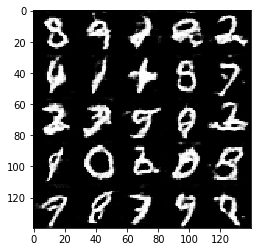

Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.1235
Epoch 2/2... Discriminator Loss: 1.1247... Generator Loss: 0.7834
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.3254
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 1.0095
Epoch 2/2... Discriminator Loss: 0.6853... Generator Loss: 1.8159
Epoch 2/2... Discriminator Loss: 0.7158... Generator Loss: 1.4938
Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 1.2122
Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 1.1716
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 1.0164


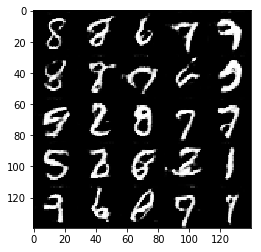

Epoch 2/2... Discriminator Loss: 1.4886... Generator Loss: 0.4575
Epoch 2/2... Discriminator Loss: 0.7341... Generator Loss: 1.4714
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 2.2401
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.1375
Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 1.1901
Epoch 2/2... Discriminator Loss: 0.5853... Generator Loss: 1.8285
Epoch 2/2... Discriminator Loss: 0.8402... Generator Loss: 1.2625
Epoch 2/2... Discriminator Loss: 0.5102... Generator Loss: 2.4406
Epoch 2/2... Discriminator Loss: 0.8158... Generator Loss: 2.4378


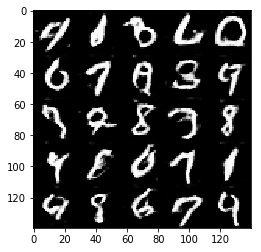

Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 0.7156... Generator Loss: 1.4852
Epoch 2/2... Discriminator Loss: 0.7926... Generator Loss: 1.1935
Epoch 2/2... Discriminator Loss: 0.6063... Generator Loss: 1.7106
Epoch 2/2... Discriminator Loss: 1.2778... Generator Loss: 2.8084
Epoch 2/2... Discriminator Loss: 0.8398... Generator Loss: 1.1718
Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 1.1976
Epoch 2/2... Discriminator Loss: 0.6042... Generator Loss: 1.7944
Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 2.4968
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.0716


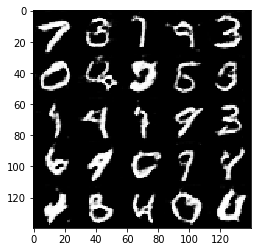

Epoch 2/2... Discriminator Loss: 0.7573... Generator Loss: 1.2738
Epoch 2/2... Discriminator Loss: 0.6627... Generator Loss: 1.6270
Epoch 2/2... Discriminator Loss: 0.9341... Generator Loss: 0.9828
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.4847
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 1.2859
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 1.0582
Epoch 2/2... Discriminator Loss: 0.5999... Generator Loss: 1.6852
Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 1.2156
Epoch 2/2... Discriminator Loss: 0.7049... Generator Loss: 1.6362


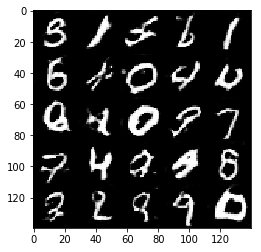

Epoch 2/2... Discriminator Loss: 0.6964... Generator Loss: 2.0347
Epoch 2/2... Discriminator Loss: 0.6022... Generator Loss: 1.8084
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 1.0512
Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 1.2648
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 0.7903... Generator Loss: 1.3165
Epoch 2/2... Discriminator Loss: 0.7045... Generator Loss: 1.3703
Epoch 2/2... Discriminator Loss: 0.5711... Generator Loss: 1.9697
Epoch 2/2... Discriminator Loss: 1.5845... Generator Loss: 0.5328
Epoch 2/2... Discriminator Loss: 0.6403... Generator Loss: 1.7924


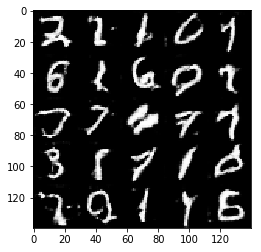

Epoch 2/2... Discriminator Loss: 0.5844... Generator Loss: 1.9160
Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 2.0172
Epoch 2/2... Discriminator Loss: 0.6322... Generator Loss: 1.8695
Epoch 2/2... Discriminator Loss: 0.7798... Generator Loss: 1.8456
Epoch 2/2... Discriminator Loss: 1.0574... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 0.6718... Generator Loss: 1.3898
Epoch 2/2... Discriminator Loss: 0.8347... Generator Loss: 1.2101
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 0.8897
Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 2.4782
Epoch 2/2... Discriminator Loss: 0.5803... Generator Loss: 1.9582


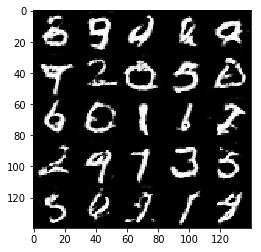

Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 1.1753
Epoch 2/2... Discriminator Loss: 0.9120... Generator Loss: 1.0385
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.0960
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 1.0544
Epoch 2/2... Discriminator Loss: 0.8923... Generator Loss: 1.1194
Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 0.5889... Generator Loss: 1.7253
Epoch 2/2... Discriminator Loss: 0.7660... Generator Loss: 1.2408
Epoch 2/2... Discriminator Loss: 0.6126... Generator Loss: 1.9339
Epoch 2/2... Discriminator Loss: 0.9476... Generator Loss: 1.0851


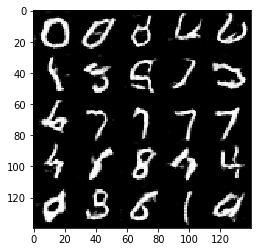

Epoch 2/2... Discriminator Loss: 0.5654... Generator Loss: 1.9529
Epoch 2/2... Discriminator Loss: 0.5944... Generator Loss: 1.9333
Epoch 2/2... Discriminator Loss: 0.6319... Generator Loss: 1.7092
Epoch 2/2... Discriminator Loss: 0.8527... Generator Loss: 1.1349
Epoch 2/2... Discriminator Loss: 0.8677... Generator Loss: 1.1056
Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 0.6432... Generator Loss: 1.5989
Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.2033
Epoch 2/2... Discriminator Loss: 0.7412... Generator Loss: 1.2756
Epoch 2/2... Discriminator Loss: 0.8951... Generator Loss: 1.0458


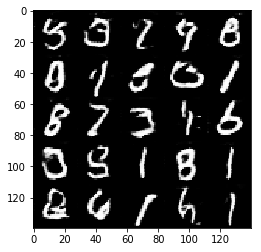

Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.8209
Epoch 2/2... Discriminator Loss: 0.6081... Generator Loss: 2.4060
Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.0815
Epoch 2/2... Discriminator Loss: 0.7364... Generator Loss: 1.4342
Epoch 2/2... Discriminator Loss: 0.5544... Generator Loss: 2.0900
Epoch 2/2... Discriminator Loss: 0.6514... Generator Loss: 1.5407
Epoch 2/2... Discriminator Loss: 0.6250... Generator Loss: 1.9535
Epoch 2/2... Discriminator Loss: 0.5464... Generator Loss: 1.8637
Epoch 2/2... Discriminator Loss: 0.5716... Generator Loss: 1.9326
Epoch 2/2... Discriminator Loss: 2.9991... Generator Loss: 0.2146


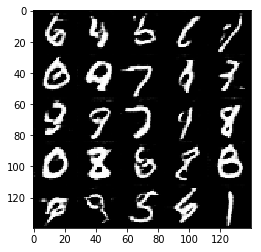

Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 1.1948
Epoch 2/2... Discriminator Loss: 0.7924... Generator Loss: 1.3997
Epoch 2/2... Discriminator Loss: 0.6365... Generator Loss: 2.3364
Epoch 2/2... Discriminator Loss: 0.7419... Generator Loss: 2.2008
Epoch 2/2... Discriminator Loss: 0.6767... Generator Loss: 1.5470
Epoch 2/2... Discriminator Loss: 0.5797... Generator Loss: 1.7448
Epoch 2/2... Discriminator Loss: 0.6258... Generator Loss: 1.6886
Epoch 2/2... Discriminator Loss: 0.6206... Generator Loss: 1.9014
Epoch 2/2... Discriminator Loss: 0.6476... Generator Loss: 1.6955
Epoch 2/2... Discriminator Loss: 0.8101... Generator Loss: 1.2536


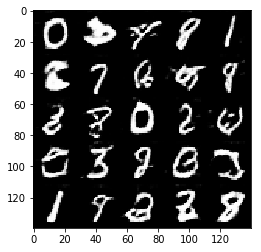

Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 1.0586
Epoch 2/2... Discriminator Loss: 0.6750... Generator Loss: 1.6409
Epoch 2/2... Discriminator Loss: 0.6785... Generator Loss: 1.5426
Epoch 2/2... Discriminator Loss: 0.6002... Generator Loss: 1.6993
Epoch 2/2... Discriminator Loss: 0.6821... Generator Loss: 1.4400
Epoch 2/2... Discriminator Loss: 0.6443... Generator Loss: 1.7342
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 1.7001
Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 1.2143
Epoch 2/2... Discriminator Loss: 0.6025... Generator Loss: 1.7143
Epoch 2/2... Discriminator Loss: 0.5984... Generator Loss: 1.7079


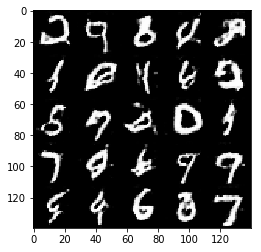

Epoch 2/2... Discriminator Loss: 0.6472... Generator Loss: 1.5073
Epoch 2/2... Discriminator Loss: 0.6859... Generator Loss: 1.5057
Epoch 2/2... Discriminator Loss: 0.6130... Generator Loss: 1.6664
Epoch 2/2... Discriminator Loss: 0.7259... Generator Loss: 1.2869
Epoch 2/2... Discriminator Loss: 0.6663... Generator Loss: 1.4934
Epoch 2/2... Discriminator Loss: 0.4858... Generator Loss: 2.3749
Epoch 2/2... Discriminator Loss: 0.5047... Generator Loss: 2.1746
Epoch 2/2... Discriminator Loss: 0.5198... Generator Loss: 2.2805
Epoch 2/2... Discriminator Loss: 0.7573... Generator Loss: 2.5366
Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 0.8562


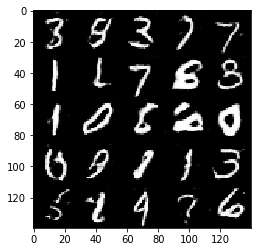

Epoch 2/2... Discriminator Loss: 0.6687... Generator Loss: 2.9405
Epoch 2/2... Discriminator Loss: 1.6535... Generator Loss: 0.5244
Epoch 2/2... Discriminator Loss: 0.6439... Generator Loss: 2.1572
Epoch 2/2... Discriminator Loss: 0.6721... Generator Loss: 1.6032
Epoch 2/2... Discriminator Loss: 0.6701... Generator Loss: 2.4799
Epoch 2/2... Discriminator Loss: 0.5979... Generator Loss: 2.0197
Epoch 2/2... Discriminator Loss: 0.5083... Generator Loss: 2.2850
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.1916
Epoch 2/2... Discriminator Loss: 0.7043... Generator Loss: 1.4783
Epoch 2/2... Discriminator Loss: 0.5809... Generator Loss: 1.7733


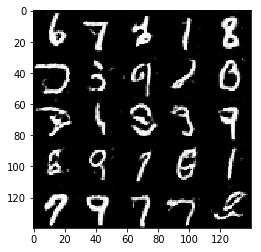

Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 1.4074
Epoch 2/2... Discriminator Loss: 0.7166... Generator Loss: 1.4300
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 2.3846
Epoch 2/2... Discriminator Loss: 0.7538... Generator Loss: 1.4266
Epoch 2/2... Discriminator Loss: 0.7549... Generator Loss: 2.7669
Epoch 2/2... Discriminator Loss: 1.6259... Generator Loss: 0.5515
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 1.2981
Epoch 2/2... Discriminator Loss: 0.6446... Generator Loss: 1.7273
Epoch 2/2... Discriminator Loss: 0.6342... Generator Loss: 1.8191
Epoch 2/2... Discriminator Loss: 0.8171... Generator Loss: 1.2277


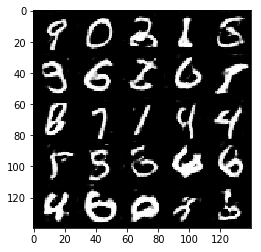

Epoch 2/2... Discriminator Loss: 0.6038... Generator Loss: 2.0335
Epoch 2/2... Discriminator Loss: 0.6192... Generator Loss: 1.9922
Epoch 2/2... Discriminator Loss: 0.5862... Generator Loss: 1.8397
Epoch 2/2... Discriminator Loss: 0.5697... Generator Loss: 1.9843
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.1219
Epoch 2/2... Discriminator Loss: 0.5876... Generator Loss: 1.6459
Epoch 2/2... Discriminator Loss: 0.8118... Generator Loss: 1.2382
Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 0.8129
Epoch 2/2... Discriminator Loss: 0.7043... Generator Loss: 1.7946
Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 1.3892


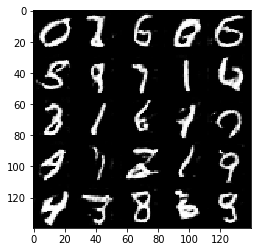

Epoch 2/2... Discriminator Loss: 0.5921... Generator Loss: 2.1759
Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 1.4514
Epoch 2/2... Discriminator Loss: 0.5561... Generator Loss: 1.8629
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.6125
Epoch 2/2... Discriminator Loss: 0.5514... Generator Loss: 1.9571
Epoch 2/2... Discriminator Loss: 0.6252... Generator Loss: 1.6032
Epoch 2/2... Discriminator Loss: 0.6112... Generator Loss: 1.6674
Epoch 2/2... Discriminator Loss: 1.6930... Generator Loss: 0.4647
Epoch 2/2... Discriminator Loss: 0.5152... Generator Loss: 2.3172
Epoch 2/2... Discriminator Loss: 0.4902... Generator Loss: 2.3993


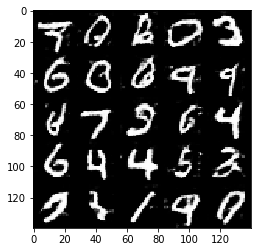

Epoch 2/2... Discriminator Loss: 0.7500... Generator Loss: 1.3388
Epoch 2/2... Discriminator Loss: 0.6338... Generator Loss: 1.7651
Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 1.5875
Epoch 2/2... Discriminator Loss: 0.5899... Generator Loss: 1.8605
Epoch 2/2... Discriminator Loss: 0.5500... Generator Loss: 1.9437


In [99]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 2.3560
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 1.9321
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 2.3114
Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 2.3252
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 1.4109
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.8740
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 2.2486
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.2142
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.4576


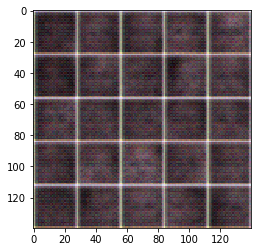

Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 2.2760... Generator Loss: 0.2293
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.8106
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 2.8337
Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 1.3542
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.4524
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7270


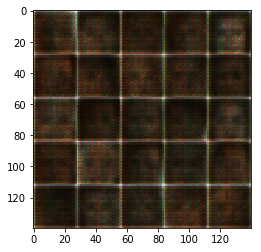

Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 0.7197... Generator Loss: 1.6535
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 2.1470
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 0.8608


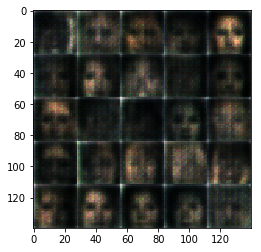

Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.8767
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.6229
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 2.4413
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.2353
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 2.4041
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.3710
Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 2.1883
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.6849
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 2.0245


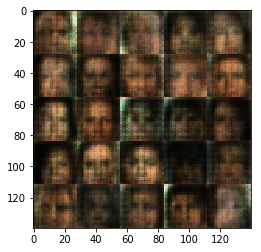

Epoch 1/1... Discriminator Loss: 1.6022... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.8264
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 1.6798
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 2.1045
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.7701


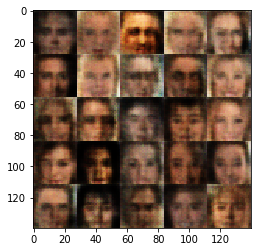

Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.3494
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.7278


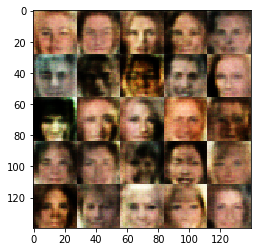

Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 0.4374
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.0557


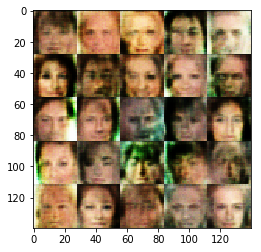

Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 2.1002
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 0.9970
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 1.8374
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.3764
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 1.3364
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.2603


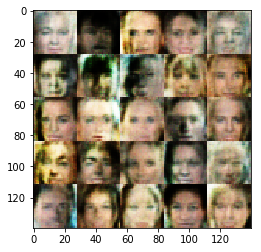

Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.5384
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 1.5021
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.4536


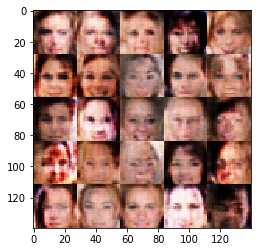

Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 1.4586
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.7925
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.8684
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.6422


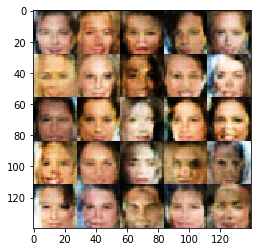

Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.3205
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.5371
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 1.3867
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 1.2165


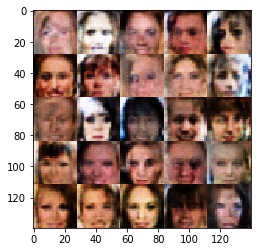

Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.3173
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.6271
Epoch 1/1... Discriminator Loss: 0.7322... Generator Loss: 1.7040
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.2142
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.5898


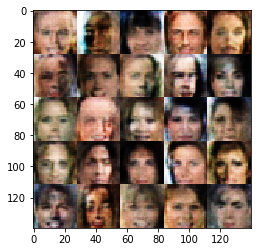

Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 0.9362... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 2.7638
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.4001
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.2954
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.1658
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.2550
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.2052


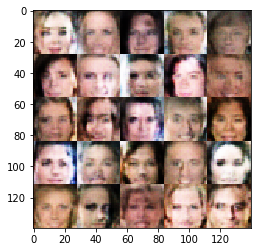

Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.5013
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 1.5332
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.1736
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.2909
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 1.0229


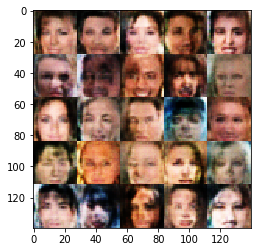

Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.8614
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 2.0644
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.4673
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.8435


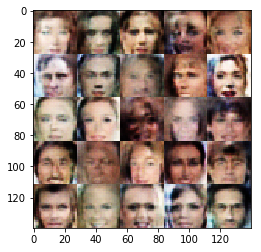

Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 0.6164... Generator Loss: 1.9582
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.4474
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.0623
Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.4978
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 1.3861


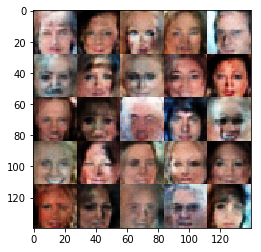

Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.4267
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 1.2043


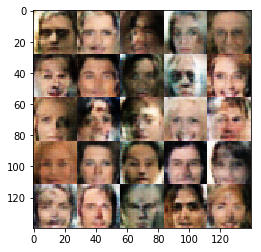

Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 2.3200
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.5623
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.5429
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.5956
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.4926
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.5266
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.9638


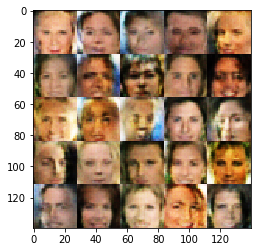

Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.1777
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 1.1894
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 1.6990


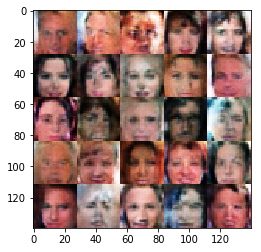

Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 2.2673
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.8017
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 1.9726
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.7944


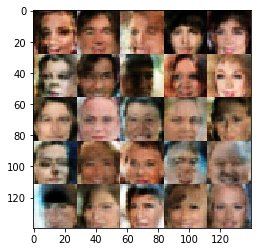

Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.2407
Epoch 1/1... Discriminator Loss: 0.6296... Generator Loss: 1.8648
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 1.7608
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 1.3434
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 1.3573


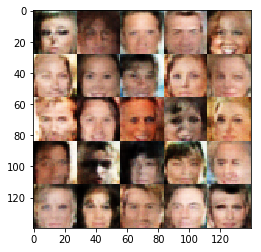

Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 1.2299
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.5137
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 1.5058
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 2.2168
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.6606


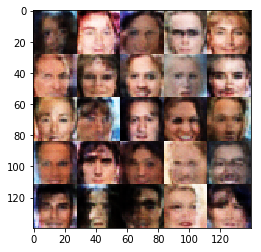

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 1.4021
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.4887
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.1396
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 1.9119
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.4848
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 2.1681


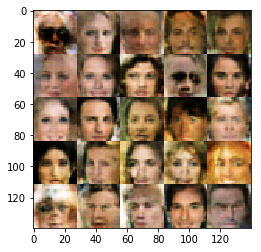

Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 1.3487
Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 1.9655
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.1637
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.8846


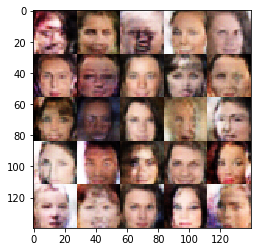

Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 1.8890
Epoch 1/1... Discriminator Loss: 1.6650... Generator Loss: 0.3662
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 1.2622
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.9553
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 2.4304
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 1.6441
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 1.2817


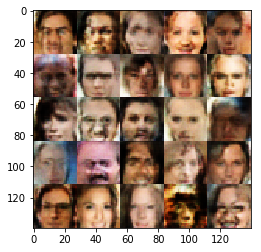

Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.4656
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 2.0299
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 1.3949
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 1.2314
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 1.6694
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.2892
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.5986


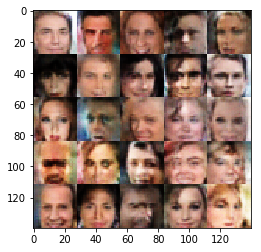

Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 2.1752
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.2037
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 2.0865
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.0596


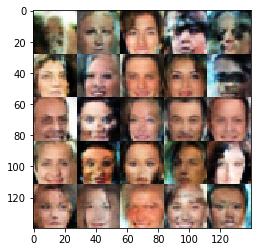

Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 0.7584... Generator Loss: 1.3494
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 2.2071
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 1.8198


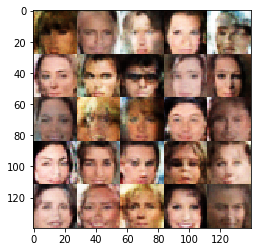

Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.1907
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 1.5307
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 1.3082
Epoch 1/1... Discriminator Loss: 0.6256... Generator Loss: 1.6740
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.8729... Generator Loss: 0.2867
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.8596


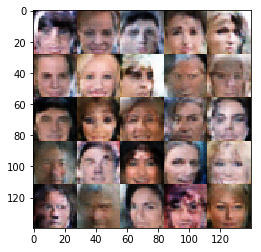

Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.6585
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 1.3624
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.1545
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.6561
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.2260
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 0.9201


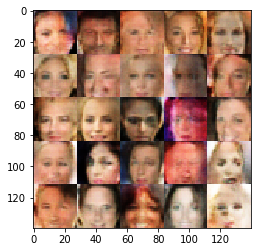

Epoch 1/1... Discriminator Loss: 0.6434... Generator Loss: 1.8933
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 1.5527
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.2384
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.5287
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 1.5021


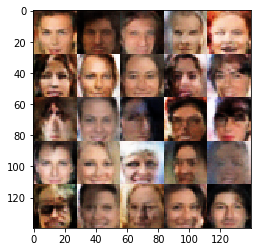

Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.9787
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.1978
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 1.6963
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.6061


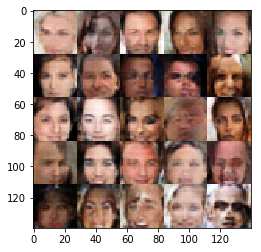

Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.8312


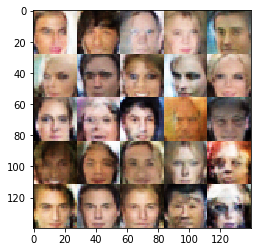

Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 1.3845
Epoch 1/1... Discriminator Loss: 0.8494... Generator Loss: 1.2479
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 0.7278... Generator Loss: 1.4850


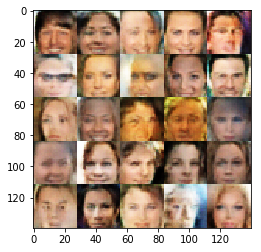

Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.3701
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.4455
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 1.5599
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 1.3117
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 1.3688


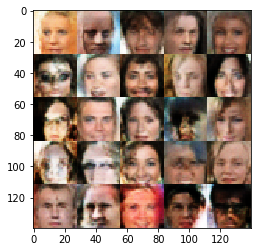

Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.7212
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 1.4304
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 2.0638
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.1354
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.0054


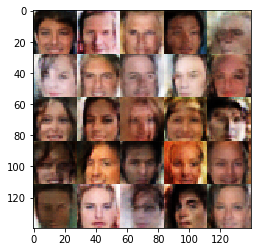

Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.6412
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 2.3169
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.5606
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.9143


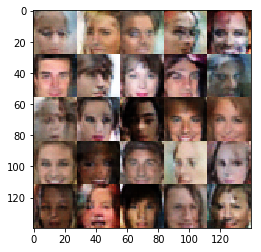

Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 1.6993
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.2097


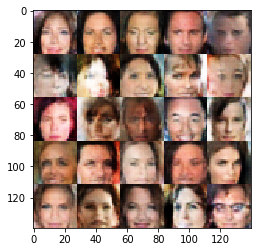

Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.4632
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.2282
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.8347


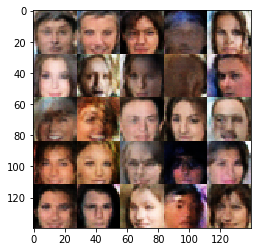

Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.0284
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 2.2950... Generator Loss: 0.2129
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.5099
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.1097


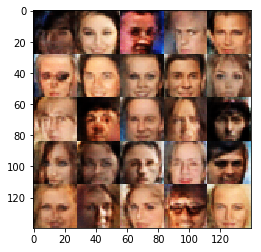

Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 1.4085
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 0.6874... Generator Loss: 2.1579
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 1.1795


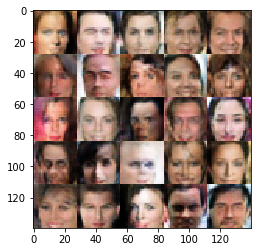

Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.4677
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 0.7300... Generator Loss: 1.5677
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.5108


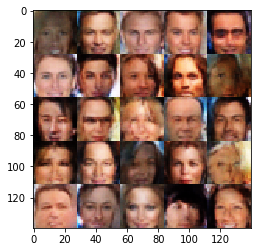

Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.1545
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.3754
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.5716


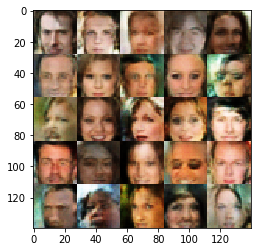

Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 0.8662... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.2966
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.3081


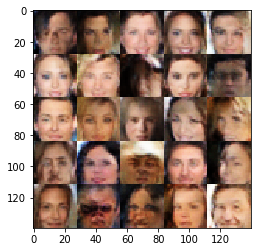

Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.4400
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 0.6334... Generator Loss: 1.6378
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.4260
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.6929


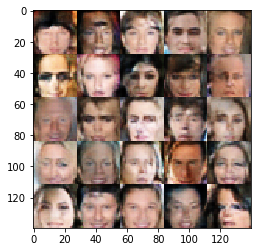

Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 1.3506
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.3546


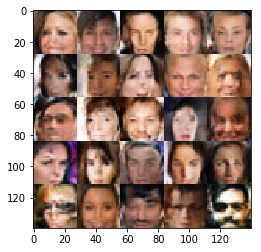

Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.6046
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.8997


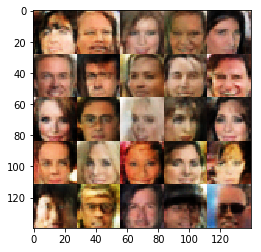

Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 2.0020
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.4224
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.8558


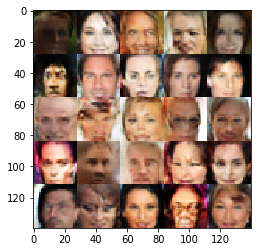

Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.6074
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 1.4431
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.5374


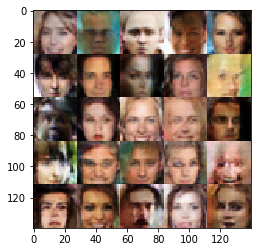

Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.3402
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.5642
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.3055


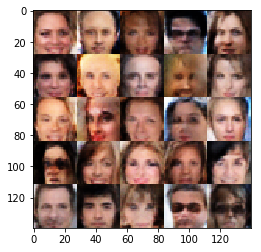

Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.2044
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.7749
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.4734
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 1.6102
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 0.8351


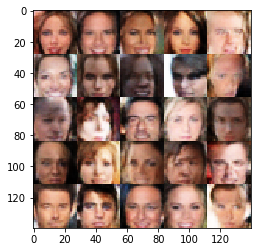

Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.5718
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.1313
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.2347
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.1507


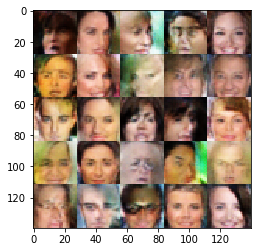

Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.2646
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.2696
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.2313


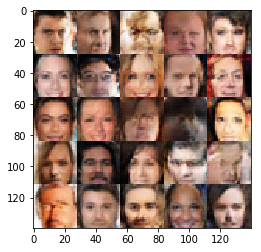

Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.4573
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.6985
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 1.9627
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.5113


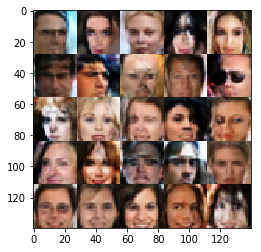

Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 1.6304
Epoch 1/1... Discriminator Loss: 0.7236... Generator Loss: 1.6218
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 0.8721


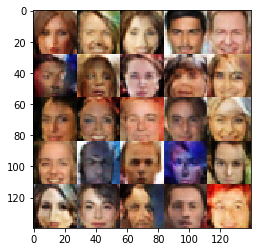

Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.0200


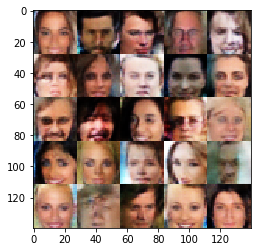

Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.3774
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.2370
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.4670
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 0.9428


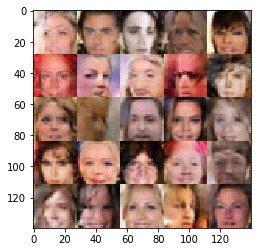

Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 1.4599
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.5293
Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 0.3891
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 1.1823


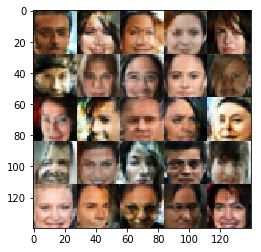

Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.4394
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.7815


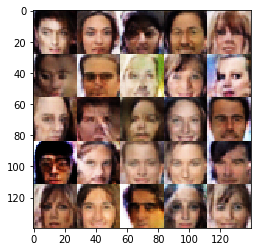

Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.1830
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.4951
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.2418


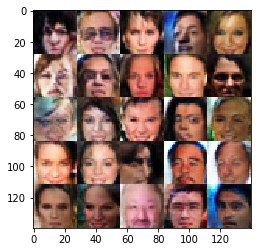

Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 1.3472
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 1.7032
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.3632
Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.4464
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 0.9894


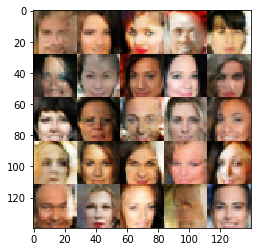

Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 1.6242
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.7279
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 1.0197


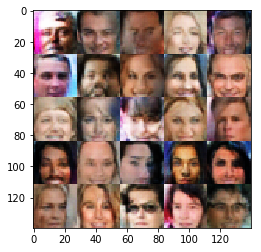

Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 1.3697
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.1952
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.5903


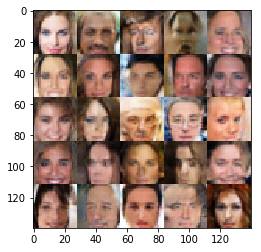

Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.7166


In [100]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.